# FrozenLake-v1 환경을 통한 Monte Carlo Method 실습


### Sampling

- sampling을 통해 추정(approximate)한다.

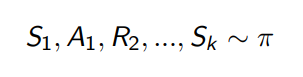



### MC prediction

- 모든 episode 진행하면서 맨 뒤 state부터 돌아오며 value function update

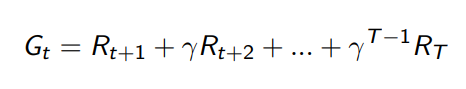
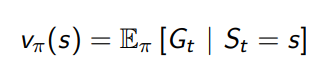

## Library Import

In [1]:
import gym
import numpy as np

**MC 에서는 episode가 종단 상태를 만나 끝에 도달해야 한다.**

FrozenLake 에서는 Goal에 도착하면 1의 reward를 얻고, 나머지 상태에서는 0의 reward를 얻는다.

In [2]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=20)

## Generate episode (sampling)

In [3]:
def generate_episode(env, policy):
    states, actions, rewards = [], [], []
    
    state = env.reset()
    
    while True:
        # Append State
        states.append(state)
        
        # Append Action
        probs = policy[state]
        action = np.random.choice(np.arange(len(probs)), p=probs)
        actions.append(action)
        
        state, reward, done, info = env.step(action)
        
        # Append reward
        rewards.append(reward)
        
        if done:
            break
    
    return states, actions, rewards

**몇번의 episode가 있어야 goal에 도달하는 episode를 얻을 수 있을까? = 처음으로 reward 1을 얻게 되는 시점은??**

- policy probability가 동일한 random policy에서 시뮬레이션해보자.
- 물론 매번 달라짐(확률적으로 발생하는 것이라..)

In [4]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=20)

policy = np.ones([env.nS, env.nA]) / env.nA

step = 0
while True:
    step += 1
    states, actions, rewards = generate_episode(env, policy)
    
    if rewards[-1] == 1.0:
        break
    
print("step:", step)
print('states:', states)
print('actions:', actions)
print('rewards:', rewards)

step: 313
states: [0, 0, 0, 0, 1, 1, 0, 0, 4, 0, 4, 8, 8, 9, 10, 14, 14]
actions: [0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 1, 1, 1, 3, 0, 0, 2]
rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


# Monte Carlo prediction for State Value function

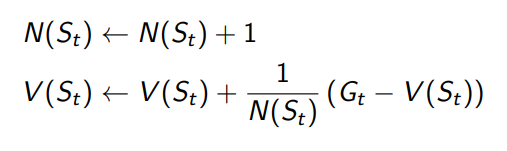

## Every-visit MC prediction

각 episode에서 마주치는 모든 state에 대해 state value function을 update한다.

In [6]:
def every_visit_MC_prediction(env, policy, n_sample, gamma = 1.0):
    
    # 특정 state를 방문한 횟수 = 평균값을 구하기 위해
    N = np.zeros(env.nS)
    
    # state value function
    V = np.zeros(env.nS)
    
    for i in range(n_sample):
        states, actions, rewards = generate_episode(env, policy)
        
        G = 0
        
        for t in range(len(states) -1, -1, -1):
            S = states[t]
            G = gamma * G + rewards[t]
            N[S] += 1
            V[S] = V[S] + (G - V[S]) / N[S]
    
    return V

In [7]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=30)

# sample의 갯수
n_sample = 50000

# random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

every_visit_Value_function = every_visit_MC_prediction(env, random_policy, n_sample, 0.9)

print('State Value function')
print(every_visit_Value_function)

State Value function
[0.0040276  0.00425713 0.00924298 0.00521236 0.00607662 0.
 0.02536079 0.         0.01744327 0.05326043 0.10288086 0.
 0.         0.10819041 0.36975879 0.        ]


## First-visit MC prediction

각 episode를 통해 backprop update 중에 마주치는 각 state는 한번씩만 update된다. (중복된 state는 update하지 않는다.)

- 구현하는 방법은 여러가지가 있을 수 있음

In [8]:
def first_visit_MC_prediction(env, policy, n_sample, gamma = 1.0):
    
    N = np.zeros(env.nS)
    V = np.zeros(env.nS)
    visit = np.zeros(env.nS, dtype=int)
    
    for i in range(1, n_sample + 1):
        states, actions, rewards = generate_episode(env, policy)
        
        G = 0
        
        for t in range(len(states) - 1, -1, -1):
            S = states[t]
            G = gamma * G + rewards[t]
            
            if visit[S] != i:
                visit[S] = i
                N[S] += 1
                V[S] = V[S] + (G - V[S]) / N[S]
    
    return V

In [9]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=30)

# sample의 갯수
n_sample = 50000

# random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

first_visit_Value_function = first_visit_MC_prediction(env, random_policy, n_sample, 0.9)

print('State Value function')
print(first_visit_Value_function)

State Value function
[0.00553637 0.00504164 0.01248073 0.00571378 0.00718346 0.
 0.02793388 0.         0.01908804 0.0583198  0.1130172  0.
 0.         0.13768801 0.426442   0.        ]


### 두 방법의 비교

In [10]:
for i in range(env.nS):
    print('{:.4f} {:.4f}'.format(every_visit_Value_function[i], first_visit_Value_function[i]))

0.0040 0.0055
0.0043 0.0050
0.0092 0.0125
0.0052 0.0057
0.0061 0.0072
0.0000 0.0000
0.0254 0.0279
0.0000 0.0000
0.0174 0.0191
0.0533 0.0583
0.1029 0.1130
0.0000 0.0000
0.0000 0.0000
0.1082 0.1377
0.3698 0.4264
0.0000 0.0000


# Monte Carlo prediction for Q-function

## Every-visit MC prediction

In [11]:
def every_visit_MC_Q_prediction(env, policy, n_sample, gamma = 1.0):
    N = np.zeros([env.nS, env.nA])
    Q = np.zeros([env.nS, env.nA])
    
    for i in range(n_sample):
        states, actions, rewards = generate_episode(env, policy)
        
        G = 0
        
        for t in range(len(states)-1, -1, -1):
            S = states[t]
            A = actions[t]
            G = gamma * G + rewards[t]
            
            N[S, A] += 1
            Q[S, A] = Q[S, A] + (G - Q[S, A]) / N[S, A]
            
    return Q

In [12]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=30)

# sample의 갯수
n_sample = 50000

# random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

every_visit_Q = every_visit_MC_Q_prediction(env, random_policy, n_sample, 0.9)

print('Action Value function')
print(every_visit_Q)

Action Value function
[[0.00433786 0.00444673 0.00413399 0.00380029]
 [0.00248622 0.00366602 0.0037207  0.00592404]
 [0.01181891 0.0094161  0.01121356 0.00593658]
 [0.00541715 0.00292858 0.00268499 0.00628461]
 [0.00862802 0.00741716 0.00668269 0.00353134]
 [0.         0.         0.         0.        ]
 [0.03080895 0.03216718 0.03160401 0.00387817]
 [0.         0.         0.         0.        ]
 [0.00801352 0.02220176 0.01868012 0.02524312]
 [0.04966744 0.07777436 0.07022006 0.03807803]
 [0.14248349 0.1256413  0.12204781 0.02808796]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.05125282 0.16794978 0.1630979  0.13356337]
 [0.18992974 0.46172248 0.46116326 0.43432378]
 [0.         0.         0.         0.        ]]


## First-visit MC prediction

In [13]:
def first_visit_MC_Q_prediction(env, policy, n_sample, gamma = 1.0):
    N = np.zeros([env.nS, env.nA])
    Q = np.zeros([env.nS, env.nA])
    visit = np.zeros([env.nS, env.nA], dtype='int')
    for i in range(1, n_sample + 1):
        states, actions, rewards = generate_episode(env, policy)
        
        G = 0
        
        for t in range(len(states)-1, -1, -1):
            S = states[t]
            A = actions[t]
            G = gamma * G + rewards[t]
            
            if visit[S, A] != i:
                visit[S, A] = i
                N[S, A] += 1
                Q[S, A] = Q[S, A] + (G - Q[S, A]) / N[S, A]
            
    return Q

In [14]:
env = gym.make('FrozenLake-v1')
env = gym.wrappers.TimeLimit(env, max_episode_steps=30)

# sample의 갯수
n_sample = 50000

# random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

first_visit_Q = first_visit_MC_Q_prediction(env, random_policy, n_sample, 0.9)

print('Action Value function')
print(first_visit_Q)

Action Value function
[[0.00548085 0.00564194 0.00521804 0.00469517]
 [0.0033126  0.00428894 0.00524275 0.0062164 ]
 [0.01306359 0.00875167 0.01412358 0.00573977]
 [0.00376248 0.00329676 0.00200584 0.00498568]
 [0.00942316 0.00808773 0.00744404 0.00313117]
 [0.         0.         0.         0.        ]
 [0.03431725 0.02960181 0.03578539 0.00253515]
 [0.         0.         0.         0.        ]
 [0.00858805 0.02600022 0.02082949 0.02734004]
 [0.05070305 0.08661176 0.07550544 0.04129288]
 [0.14122652 0.15428642 0.12610315 0.02335904]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.06568902 0.1430148  0.18811095 0.14660498]
 [0.19655041 0.51930959 0.48052102 0.42811732]
 [0.         0.         0.         0.        ]]


### 두 방법의 비교

In [15]:
for i in range(env.nS):
    print('{}\n{}\n'.format(np.round(every_visit_Q[i], 4), np.round(first_visit_Q[i], 4)))

[0.0043 0.0044 0.0041 0.0038]
[0.0055 0.0056 0.0052 0.0047]

[0.0025 0.0037 0.0037 0.0059]
[0.0033 0.0043 0.0052 0.0062]

[0.0118 0.0094 0.0112 0.0059]
[0.0131 0.0088 0.0141 0.0057]

[0.0054 0.0029 0.0027 0.0063]
[0.0038 0.0033 0.002  0.005 ]

[0.0086 0.0074 0.0067 0.0035]
[0.0094 0.0081 0.0074 0.0031]

[0. 0. 0. 0.]
[0. 0. 0. 0.]

[0.0308 0.0322 0.0316 0.0039]
[0.0343 0.0296 0.0358 0.0025]

[0. 0. 0. 0.]
[0. 0. 0. 0.]

[0.008  0.0222 0.0187 0.0252]
[0.0086 0.026  0.0208 0.0273]

[0.0497 0.0778 0.0702 0.0381]
[0.0507 0.0866 0.0755 0.0413]

[0.1425 0.1256 0.122  0.0281]
[0.1412 0.1543 0.1261 0.0234]

[0. 0. 0. 0.]
[0. 0. 0. 0.]

[0. 0. 0. 0.]
[0. 0. 0. 0.]

[0.0513 0.1679 0.1631 0.1336]
[0.0657 0.143  0.1881 0.1466]

[0.1899 0.4617 0.4612 0.4343]
[0.1966 0.5193 0.4805 0.4281]

[0. 0. 0. 0.]
[0. 0. 0. 0.]



# Monte Carlo Control with ${\varepsilon}$-Greedy

## TODO
- 그림과 함께 설명 추가
- Dynamic Programming의 Policy iteration과 어떤 차이가 있는지
- epsilon greedy 방법 설명 (탐험)

설명 추가
- Q function 사용
- epsilon greedy
- value iteration 차용
- GILE: Greedy in the Limit Infinite Exploration